In [5]:
import torch
x = torch.tensor([1., 2.])
w = torch.tensor([2., 2.], requires_grad=True)

f = w.t().dot(x)
f.backward()
print(w.grad)

tensor([1., 2.])


In [ ]:
import torch
from sklearn import datasets

samples, labels = datasets.make_regression(n_samples=1000, n_features=1, noise=2, random_state=42)

samples, labels = torch.from_numpy(samples), torch.from_numpy(labels)

# normalization
samples -= samples.min()
samples /= samples.max()
samples = samples.ravel()

print(samples[:5], labels[:5])


tensor([0.2090, 0.6024, 0.3882, 0.4832, 0.5592], dtype=torch.float64) tensor([-30.1187,  14.5262, -10.1193,   1.7002,  12.3453], dtype=torch.float64)


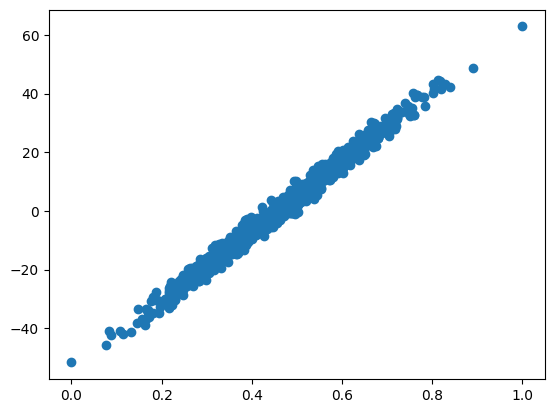

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(samples, labels)

In [ ]:
def model(x, w, b):
    return w * x + b

def loss_fn(y_pred, y_true):
    squared_diffs = (y_pred - y_true)**2
    return squared_diffs.mean()

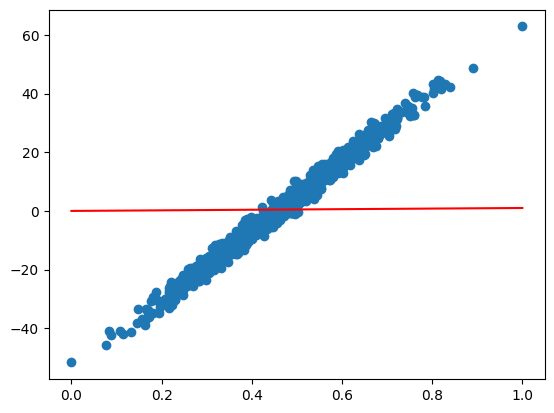

In [ ]:
def plot_line(w, b):
    x_axis = torch.linspace(0, 1, 100)
    y_axis = w * x_axis + b
    plt.plot(x_axis.detach().numpy(), y_axis.detach().numpy(), color='r')

def plot_points(samples, labels):
    plt.scatter(samples, labels)

params = torch.tensor([1.0, 0.0], requires_grad=True)

plot_line(*params)
plot_points(samples, labels)


In [ ]:
loss = loss_fn(model(samples, *params), labels)
print(loss)

loss.backward()

tensor(267.3998, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [ ]:
print(params.grad)

tensor([-4.3618,  0.2545])


In [ ]:
def training_loop(n_epochs, learning_rate, params, x, y):
    for epoch in range(1, n_epochs+1):
        y_pred = model(x, *params)
        loss = loss_fn(y_pred, y)
        loss.backward()
        with torch.no_grad():
            params -= learning_rate * params.grad
        if epoch % 500 == 0:
            print("Epoch: %d, Loss %f" % (epoch, float(loss)))
        params.grad.zero_()
    return params

params = torch.tensor([1.0, 0.5], requires_grad=True)
print(params)
trained_params = training_loop(5000, 1e-1, params, samples, labels)
print(trained_params)

tensor([1.0000, 0.5000], requires_grad=True)
Epoch: 500, Loss 15.420625
Epoch: 1000, Loss 4.418892
Epoch: 1500, Loss 3.942303
Epoch: 2000, Loss 3.921658
Epoch: 2500, Loss 3.920764
Epoch: 3000, Loss 3.920725
Epoch: 3500, Loss 3.920723
Epoch: 4000, Loss 3.920723
Epoch: 4500, Loss 3.920723
Epoch: 5000, Loss 3.920723
tensor([118.6482, -54.2016], requires_grad=True)


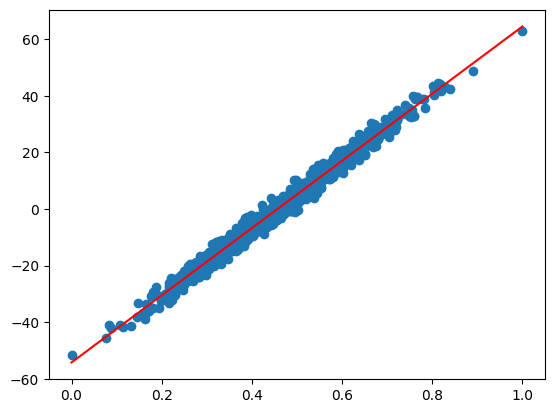

In [ ]:
plot_line(*params)
plot_points(samples, labels)

tensor([1.0000, 0.5000], requires_grad=True)
Epoch 500, Loss 104.013999
Epoch 1000, Loss 32.687075
Epoch 1500, Loss 9.436693
Epoch 2000, Loss 4.522878
Epoch 2500, Loss 3.951908
Epoch 3000, Loss 3.921340
Epoch 3500, Loss 3.920727
Epoch 4000, Loss 3.920723
Epoch 4500, Loss 3.920723
Epoch 5000, Loss 3.920723


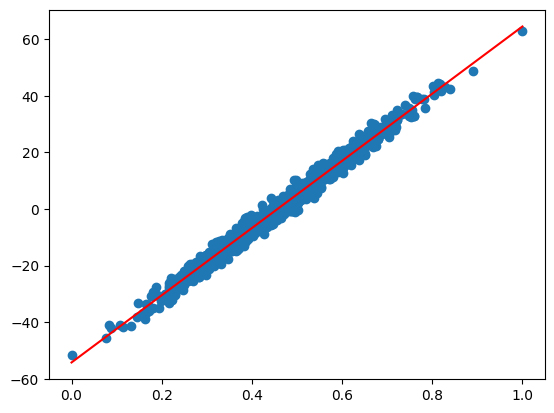

In [ ]:
from torch.optim import Adam

params = torch.tensor([1.0, 0.5], requires_grad=True)

def training_loop(n_epochs, learning_rate, params, x, y):
    optimizer = Adam([params], lr=learning_rate)
    for epoch in range(1, n_epochs + 1):
        y_pred = model(x, *params)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
        params.grad.zero_()
    return params

print(params)
training_loop(5000, 1e-1, params, samples, labels)

plot_line(*params)
plot_points(samples, labels)

tensor([1.0000, 0.5000], requires_grad=True)
Epoch 500, Loss 104.013999
Epoch 1000, Loss 32.687075
Epoch 1500, Loss 9.436693
Epoch 2000, Loss 4.522878
Epoch 2500, Loss 3.951908
Epoch 3000, Loss 3.924809
Epoch 3500, Loss 3.924809
Epoch 4000, Loss 3.924809
Epoch 4500, Loss 3.924809
Epoch 5000, Loss 3.924809


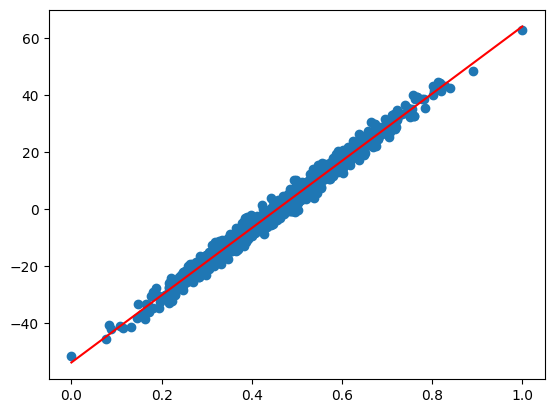

In [ ]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

params = torch.tensor([1.0, 0.5], requires_grad=True)

def training_loop(n_epochs, learning_rate, params, x, y):
    optimizer = Adam([params], lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min')

    for epoch in range(1, n_epochs + 1):
        y_pred = model(x, *params)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
        params.grad.zero_()
        scheduler.step(loss)
    return params

print(params)
training_loop(5000, 1e-1, params, samples, labels)

plot_line(*params)
plot_points(samples, labels)

0.40664029121398926 0.17633867263793945
Epoch 500, Loss 106.346718
Epoch 1000, Loss 33.873760
Epoch 1500, Loss 9.817546
Epoch 2000, Loss 4.589797
Epoch 2500, Loss 3.957299
Epoch 3000, Loss 3.924912
Epoch 3500, Loss 3.924912
Epoch 4000, Loss 3.924912
Epoch 4500, Loss 3.924912
Epoch 5000, Loss 3.924912


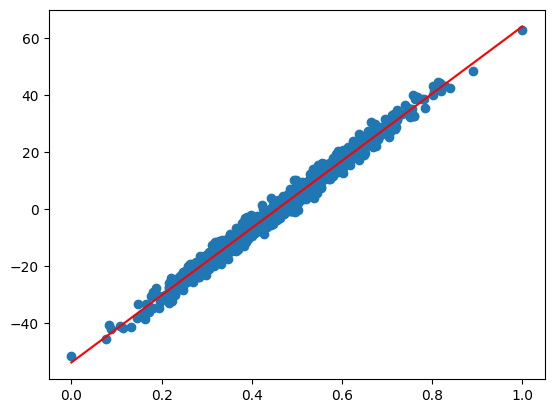

In [ ]:
linear_model = torch.nn.Linear(1, 1)

def training_loop_module(n_epochs, learning_rate, model, x,  y):
    optimizer = Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    loss_fn = torch.nn.MSELoss()
    for epoch in range(1, n_epochs + 1):
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
        optimizer.step()
        scheduler.step(loss)
        optimizer.zero_grad()

print(linear_model.weight.item(), linear_model.bias.item())

training_loop_module(5000, 1e-1, linear_model, samples.float().unsqueeze(1),
                     labels.float().unsqueeze(1))

def plot_module(model):
    x_axis = torch.linspace(0, 1, 100).unsqueeze(1)
    y_axis = model(x_axis)
    plt.plot(x_axis.detach().numpy(), y_axis.detach().numpy(), color='r')

plot_points(samples, labels)
plot_module(linear_model)



Epoch 500, Loss 9.513858
Epoch 1000, Loss 9.512505
Epoch 1500, Loss 9.510979
Epoch 2000, Loss 9.509339
Epoch 2500, Loss 9.507668
Epoch 3000, Loss 9.505982
Epoch 3500, Loss 9.504293
Epoch 4000, Loss 9.502602
Epoch 4500, Loss 9.500910
Epoch 5000, Loss 9.499213


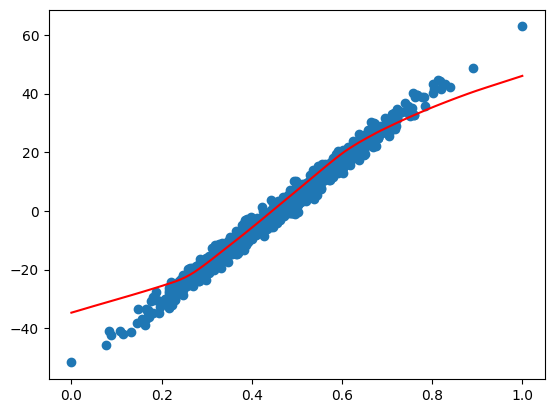

In [ ]:
dnn = torch.nn.Sequential(
    torch.nn.Linear(1, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1),
)

training_loop_module(5000, 1e-1, dnn, samples.float().unsqueeze(1), labels.float().unsqueeze(1))

def plot_module(model):
    x_axis = torch.linspace(0, 1, 100).unsqueeze(1)
    y_axis = model(x_axis)
    plt.plot(x_axis.detach().numpy(), y_axis.detach().numpy(), color='r')

plot_module(dnn)
plot_points(samples, labels)


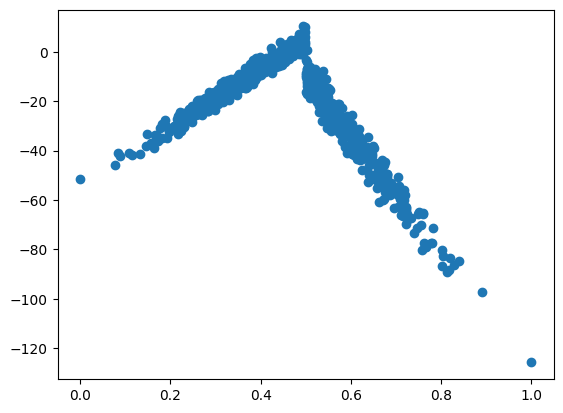

In [ ]:
y_new = labels.clone()
y_new[samples>0.5] *= -2

plot_points(samples, y_new)

Epoch 500, Loss 278.615753
Epoch 1000, Loss 34.051826
Epoch 1500, Loss 14.689840
Epoch 2000, Loss 12.953208
Epoch 2500, Loss 11.060854
Epoch 3000, Loss 10.480500
Epoch 3500, Loss 10.061985
Epoch 4000, Loss 9.686810
Epoch 4500, Loss 9.333203
Epoch 5000, Loss 9.105640


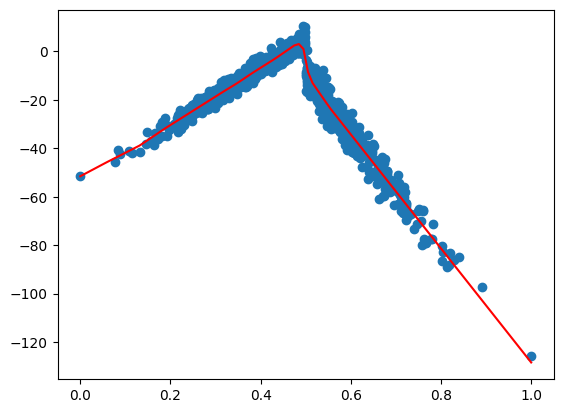

In [ ]:
y_new = labels.clone()
y_new[samples>0.5] *= -2

dnn = torch.nn.Sequential(
    torch.nn.Linear(1, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1),
)

training_loop_module(5000, 1e-1, dnn, samples.float().unsqueeze(1), y_new.float().unsqueeze(1))

plot_module(dnn)
plot_points(samples, y_new)

Epoch 500, Loss 15.044905
Epoch 1000, Loss 14.685601
Epoch 1500, Loss 14.526325
Epoch 2000, Loss 14.435581
Epoch 2500, Loss 14.430883
Epoch 3000, Loss 14.430883
Epoch 3500, Loss 14.430883
Epoch 4000, Loss 14.430883
Epoch 4500, Loss 14.430883
Epoch 5000, Loss 14.430883


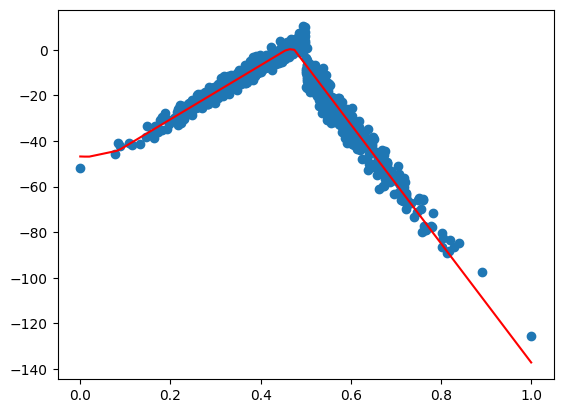

In [ ]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        """Defines the layers"""
        super().__init__()
        self.fc1 = torch.nn.Linear(1, 10)
        self.fc2 = torch.nn.Linear(10, 10)
        self.out = torch.nn.Linear(10, 1)
        # no need to define the relu twice
        # we can call it in the forward
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        """Defines the operations applied to x"""
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        out = self.out(x)
        return out

dnn_2 = NeuralNetwork()
training_loop_module(5000, 1e-1, dnn_2, samples.float().unsqueeze(1), y_new.float().unsqueeze(1))


plot_module(dnn_2)
plot_points(samples, y_new)